## Plots

In [1]:
from itertools import product
import os

import matplotlib
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

def query_gap(df, experiment, metric):
    return df.loc[f"{metric}_{experiment}_A0_q50"] - df.loc[f"{metric}_{experiment}_A1_q50"]

def print_metric_ci(name, metric):
    print(f"{name} = {100 * metric.median():.1f} ({100 * np.quantile(metric, 0.05):.1f}, {100*np.quantile(metric, 0.95):.1f})")


def query_metrics(df, experiment, metric):
    a0 = df[f"{metric}_{experiment}_A0"]
    a1 = df[f"{metric}_{experiment}_A1"]
    if metric == "xauc": # hacky -- stored wrong way in records
        a0 = 1 - a0
        a1 = 1 - a1
    print_metric_ci(f"{metric.upper()} (A=0)", a0)
    print_metric_ci(f"{metric.upper()} (A=1)", a1)
    print_metric_ci(f"D{metric.upper()}", np.abs(a0-a1))
    print(f"Noise rate (A=0): {100*df['Pr[Y_obs!=Y|A=0]_train'].median():.1f}")
    print(f"Noise rate (A=1): {100*df['Pr[Y_obs!=Y|A=1]_train'].median():.1f}")
    print(f"Test rate (A=0): {100*df['Pr[T=1|A=0]_train'].median():.1f}")
    print(f"Test rate (A=1): {100*df['Pr[T=1|A=1]_train'].median():.1f}")

def query_noise_rate(df):
    return df.loc["Pr[Y_obs!=Y|A=1]_train_q50"]

## Retrieving raw results: Example
 
This shows an example of how to retrieve the raw performance gap values with empirical 95% CIs from the CSV files containing results (from running the scripts). You will need to run `scripts/setting2_full.csv` first.

All results are stored in the results directory, with the following structure:

```
results/
├── <experiment_name>
    ├── full.csv # metrics and simulation stats w/ empirical confidence intervals for each replication
    ├── cis.csv # raw csv file showing just confidence interval info
    ├── roc_curves.pkl # Pickle containing ROC curves for each replication
    ├── models/ 
```

In [6]:
df = pd.read_csv("results/SETTING2_BASE_5_6.2/full.csv", index_col=0, quotechar="|") 
query_metrics(df, "SVMExperiment", "xauc")

XAUC (A=0) = 99.0 (98.8, 99.1)
XAUC (A=1) = 91.5 (90.4, 92.6)
DXAUC = 7.5 (6.4, 8.5)
Noise rate (A=0): 0.0
Noise rate (A=1): 37.7
Test rate (A=0): 31.5
Test rate (A=1): 53.8


# Setting 2: Plots

In [10]:
def process_mapping_dict(d):
    return zip(*[[f"{k}={val}" for val in v] for k, v in d.items()])

def disparity_boxplot(
    df_list,
    fname,
    test_col,
    test_label,
    metrics=["AUC", "xAUC"],
    title_suffix=", undertested high-risk group",
    experiment_name="SVMExperiment",
    experiment_xgap=0.4,
    group_xgap=0.1,
    start=0.,
    padding=0.2,
    ci=95.,
    y_cmap="crest",
    y_obs_cmap="crest",
    lim=[(-0.03, 0.1), (-0.03, 0.25)],
    figsize=(4., 2.),
    title_mapping=None,
    legend_title="Model",
    oracle_x_col="Pr[T=1|A=1]_train",
    undertested_group=1,
    alt_ax_label = "Missed positive rate",#\n" + r"$P_1(\tilde{y}=0|y=1)$",
    xlabel=r"Degree of undertesting (group A=1, $\tau_1$ - $\tau_0$)"
): 
    final_figsize = (figsize[0] * len(metrics), figsize[1])
    fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=final_figsize)
    y_obs_colors = np.array(sns.color_palette(y_obs_cmap))

    lq, uq = (100 - ci) / 200, 1 - (100 - ci) / 200
    title = fig.suptitle("Group $\Delta$AUC and $\Delta$xAUC" + title_suffix)

    for r, metric in enumerate(metrics):
        metric_shortname = metric.split()[0].lower()
        axs[r].set_ylabel("$\Delta$" + f"{metric}")
        axs[r].set_ylim(*lim[r])
        ticklabels = next(iter(title_mapping.values()))
        axs[r].set_xticks(np.arange(start, start + experiment_xgap * len(df_list), experiment_xgap))
        axs[r].set_xlabel(xlabel)
        
        oracle_x = [start + c * experiment_xgap for c in range(len(df_list))]
        oracle_y = []
        oracle_lerr = []
        oracle_uerr = []
        exp_y = []
        dc_y = []
        alt_y = []
        alt_y_total = []
        
        alt_ax = axs[r].twinx()
        alt_ax.tick_params('y', colors='tab:red')
        alt_ax.set_ylabel(alt_ax_label, color="tab:red")
        alt_ax.spines["right"].set_edgecolor("tab:red")
        alt_ax.set_ylim((lim[r][0] * 1.1 / lim[r][1], 1.1))

        for c, df in enumerate(df_list):
            oracle_diff = df[f"{metric_shortname}_oracle_A1"] - df[f"{metric_shortname}_oracle_A0"]
            oracle_y.append(oracle_diff.median())
            olq = np.quantile(oracle_diff, 0.05)
            ouq = np.quantile(oracle_diff, 0.95)
            oracle_lerr.append(olq)
            oracle_uerr.append(ouq)
               
            diff = df[f"{metric_shortname}_{experiment_name}_A1"] - df[f"{metric_shortname}_{experiment_name}_A0"]
            exp_y.append(diff.median())
            yerr = [
                    [(diff.median() - diff.quantile(q=lq)).item()],
                    [(diff.quantile(q=uq) - diff.median()).item()]
                ]  
            axs[r].errorbar(
                oracle_x[c],
                diff.median(),
                yerr=yerr,
                fmt='.-',
                capsize=4, 
                color=y_obs_colors[1],
            )
            missed_total = df[f"Pr[Y_obs!=Y]_train"] / df[f"Pr[Y=1]_train"]
            missed = df[f"Pr[Y_obs!=Y|A={undertested_group}]_train"]/ df[f"Pr[Y=1|A={undertested_group}]_train"] 
            
            alt_y.append(missed.median())
            alt_y_total.append(missed_total.median())
            
            alt_yerr = [
                    [(missed.median() - missed.quantile(q=lq)).item()],
                    [(missed.quantile(q=uq) - missed.median()).item()]
            ]
            alt_yerr_total = [
                    [(missed_total.median() - missed_total.quantile(q=lq)).item()],
                    [(missed_total.quantile(q=uq) - missed_total.median()).item()]
            ]
            alt_ax.errorbar(
                oracle_x[c],
                missed_total.median(),
                yerr=alt_yerr_total,
                fmt='.-',
                capsize=4,
                color='tab:red'
            )
            alt_ax.errorbar(
                oracle_x[c],
                missed.median(),
                yerr=alt_yerr,
                fmt='.-',
                capsize=4, 
                color='tab:red',
            )

        alt_ax.plot(oracle_x, alt_y, color="tab:red", linestyle="dashed")
        alt_ax.plot(oracle_x, alt_y_total, color="tab:red")
        axs[r].plot(oracle_x, exp_y, label="baseline", color=y_obs_colors[1])
        axs[r].plot(oracle_x, oracle_y, label="oracle", linestyle='dashed', color='#888888')
        axs[r].fill_between(oracle_x, oracle_lerr, oracle_uerr, color="#cccccc", alpha=0.5)
    legend_lines = [Line2D([0], [0], color='#888888', lw=2, linestyle='dashed'),
                    Line2D([0], [0], color=y_obs_colors[1], lw=2),
                    
                   ]    
    alt_legend_lines = [Line2D([0], [0], color="tab:red", lw=2),
                        Line2D([0], [0], color="tab:red", lw=2, linestyle="dashed"),
                   ]   
    lgd = fig.legend(
        legend_lines,
        [r"Trained on $y$", r"Trained on $\tilde{y}$"], 
        bbox_to_anchor=(0.5, 0.),
        ncol=2,
        title=legend_title,
    )
 
    alt_lgd = fig.legend(
        alt_legend_lines,
        ["Overall", f"Within group a={undertested_group}"], 
        bbox_to_anchor=(0.9, 0.),
        ncol=2,
        title="Missed positives",
    ) 
    fig.tight_layout()
    plt.savefig(fname, bbox_extra_artists=(lgd, title), bbox_inches='tight')
    plt.show()
    

def covariate_shift_boxplot(
    df_list,
    fname,
    oracle_x,
    test_col,
    test_label,
    metrics=["AUC", "xAUC"],
    title_suffix=", undertested high-risk group",
    experiment_name="SVMExperiment",
    experiment_xgap=0.5,
    xlabel="",
    group_xgap=0.1,
    start=0.5,
    padding=0.2,
    ci=95.,
    y_cmap="crest",
    y_obs_cmap="crest",
    lim=[(-0.03, 0.1), (-0.03, 0.25)],
    figsize=(4., 2.),
    undertested_group=1,
    title_mapping=None,
    legend_title=None,
    alt_ax_label = "Missed positive rate",#\n" + r"$P(\tilde{y}=0|y=1)$",
):
    final_figsize = (figsize[0] * len(metrics), figsize[1])
    fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=final_figsize)
    y_obs_colors = np.array(sns.color_palette(y_obs_cmap))
    lq, uq = (100 - ci) / 200, 1 - (100 - ci) / 200
    title = fig.suptitle(f"Group $\Delta$AUC and $\Delta$xAUC" + title_suffix)
        

    for r, metric in enumerate(metrics):
        metric_shortname = metric.split()[0].lower()
        axs[r].set_ylabel("$\Delta$" + f"{metric}")
        axs[r].set_ylim(*lim[r])
        ticklabels = []
        ticklabels = [", ".join(item) for item in process_mapping_dict(title_mapping)]
        axs[r].set_xlabel(xlabel)
        
    
        oracle_y = []
        oracle_lerr = []
        oracle_uerr = []
        exp_y = []
        dc_y = []
        
        alt_y = []
        alt_y_total = []
        
        alt_ax = axs[r].twinx()
        alt_ax.tick_params('y', colors='tab:red')
        alt_ax.set_ylabel(alt_ax_label, color="tab:red")
        alt_ax.spines["right"].set_edgecolor("tab:red")
        alt_ax.set_ylim((lim[r][0] * 0.8 / lim[r][1], 0.8))
        
        for c, df in enumerate(df_list):
            oracle_diff = df[f"{metric_shortname}_oracle_A1"] - df[f"{metric_shortname}_oracle_A0"]
            oracle_y.append(oracle_diff.median())
            olq = np.quantile(oracle_diff, 0.05)
            ouq = np.quantile(oracle_diff, 0.95)
            oracle_lerr.append(olq)
            oracle_uerr.append(ouq)
            
            diff = df[f"{metric_shortname}_{experiment_name}_A1"] - df[f"{metric_shortname}_{experiment_name}_A0"]
            exp_y.append(diff.median())
            yerr = [
                    [(diff.median() - diff.quantile(q=lq)).item()],
                    [(diff.quantile(q=uq) - diff.median()).item()]
                ]  
            axs[r].errorbar(
                oracle_x[c],
                diff.median(),
                yerr=yerr,
                fmt='.-',
                capsize=4, 
                color=y_obs_colors[1],
            )
            missed_total = df[f"Pr[Y_obs!=Y]_train"] / df[f"Pr[Y=1]_train"]
            missed = df[f"Pr[Y_obs!=Y|A={undertested_group}]_train"]/ df[f"Pr[Y=1|A={undertested_group}]_train"] 
            
            alt_y.append(missed.median())
            alt_y_total.append(missed_total.median())
            
            alt_yerr = [
                    [(missed.median() - missed.quantile(q=lq)).item()],
                    [(missed.quantile(q=uq) - missed.median()).item()]
            ]
            alt_yerr_total = [
                    [(missed_total.median() - missed_total.quantile(q=lq)).item()],
                    [(missed_total.quantile(q=uq) - missed_total.median()).item()]
            ]
            alt_ax.errorbar(
                oracle_x[c],
                missed_total.median(),
                yerr=alt_yerr_total,
                fmt='.-',
                capsize=4,
                color='tab:red'
            )
            alt_ax.errorbar(
                oracle_x[c],
                missed.median(),
                yerr=alt_yerr,
                fmt='.-',
                capsize=4, 
                color='tab:red',
            )

        alt_ax.plot(oracle_x, alt_y, color="tab:red", linestyle="dashed")
        alt_ax.plot(oracle_x, alt_y_total, color="tab:red")
        axs[r].plot(oracle_x, exp_y, label="biased", color=y_obs_colors[1])
        axs[r].plot(oracle_x, oracle_y, label="oracle", linestyle='dashed', color='#888888')
        axs[r].fill_between(oracle_x, oracle_lerr, oracle_uerr, color="#cccccc", alpha=0.5)

    legend_lines = [Line2D([0], [0], color='#888888', lw=2, linestyle='dashed'),
                    Line2D([0], [0], color=y_obs_colors[1], lw=2),
                    
                   ]    
    alt_legend_lines = [Line2D([0], [0], color="tab:red", lw=2),
                        Line2D([0], [0], color="tab:red", lw=2, linestyle="dashed"),
                   ]   
    lgd = fig.legend(
        legend_lines,
        [r"Trained on $y$", r"Trained on $\tilde{y}$"], 
        bbox_to_anchor=(0.5, 0.),
        ncol=2,
        title=legend_title,
    )
 
    alt_lgd = fig.legend(
        alt_legend_lines,
        ["Overall", f"Within group a={undertested_group}"], 
        bbox_to_anchor=(0.9, 0.),
        ncol=2,
        title="Missed positives",
    ) 
    fig.tight_layout()
    plt.savefig(fname, bbox_extra_artists=(lgd, alt_lgd, title), bbox_inches='tight')
    plt.show()


## Setting 2, Undertesting the high-risk group

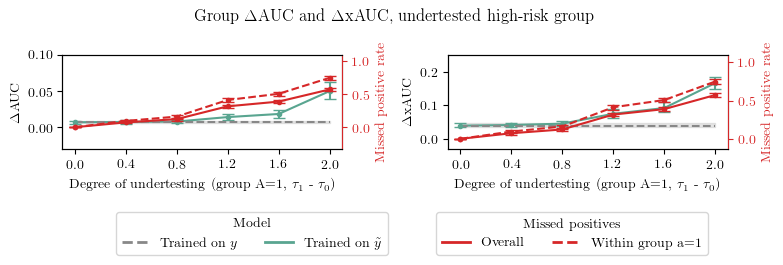

In [11]:
# Fig. 7 
df_list = [
    pd.read_csv(
        f"results/SETTING2_BASE_5_{i}/full.csv", # results for each run are in the folder with name SETTING2_$\tau_0$_$\tau_1$
        index_col=0,
        quotechar="|",
    ) for i in [5, 5.4, 5.8, 6.2, 6.6, 7]
]
disparity_boxplot(
    df_list,
    "figures/setting2_highrisk_undertested.pdf",
    'Pr[T=1|A=1]_train',
    "Test rate (group 1)",
    title_mapping={
        "$t_1$": [5, 5.4, 5.8, 6.2, 6.6, 7.],
    },
)

## Setting 2, Undertesting the low-risk group

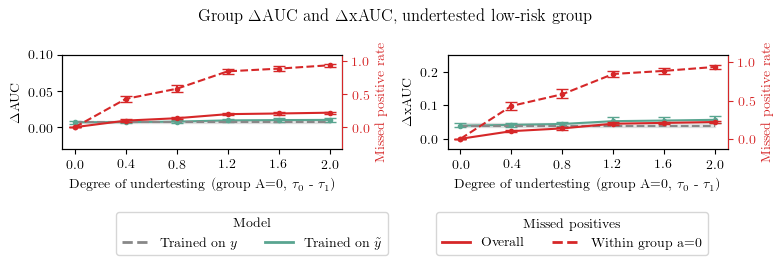

In [12]:
# Fig. 8
df_list = [
    pd.read_csv(
        f"results/SETTING2_BASE_{i}_5/full.csv",
        index_col=0,
        quotechar="|",
    ) for i in [5, 5.4, 5.8, 6.2, 6.6, 7]
]
disparity_boxplot(
    df_list,
    "figures/setting2_lowrisk_undertested.pdf",
    'Pr[T=1|A=0]_train',
    "Test rate (group 0)",
    undertested_group=0,
    title_mapping={
        "$t_1$": [5, 5.4, 5.8, 6.2, 6.6, 7.],
    },
    title_suffix=", undertested low-risk group",
    oracle_x_col="Pr[Y_obs!=Y|A=0]_train",
    xlabel=r"Degree of undertesting (group A=0, $\tau_0$ - $\tau_1$)",
    alt_ax_label="Missed positive rate"# \n" + r"$P_0(\tilde{y}=0|y=1)$"
)

## Setting 2 (supplementary), variance

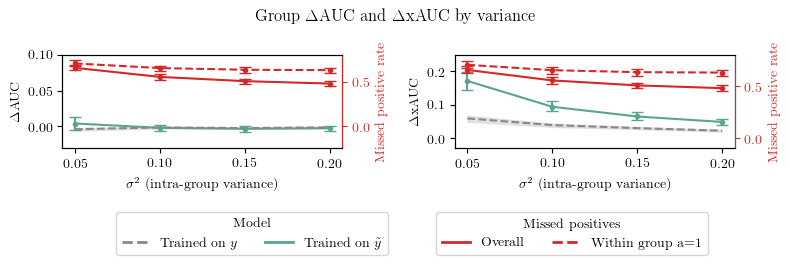

In [13]:
df_list = [
    pd.read_csv(f"results/SETTING2_BASE_5_6.6_var{i}/full.csv", index_col=0, quotechar="|") for i in [0.05, 0.1, 0.15, 0.2]
]
covariate_shift_boxplot(
    df_list, "figures/setting2_variance.pdf",[0.05, 0.1, 0.15, 0.2],
        'Pr[T=1|A=1]_train',
    "Test rate (group 1)",
    title_suffix=" by variance",
    legend_title="Model",
    xlabel="$\sigma^2$ (intra-group variance)",
    title_mapping={"$\sigma$": [0.05, 0.1, 0.15, 0.2]},
    lim=[(-0.03, 0.1), (-0.03, 0.25)],
)

## Setting 2 (supplementary), mean distance

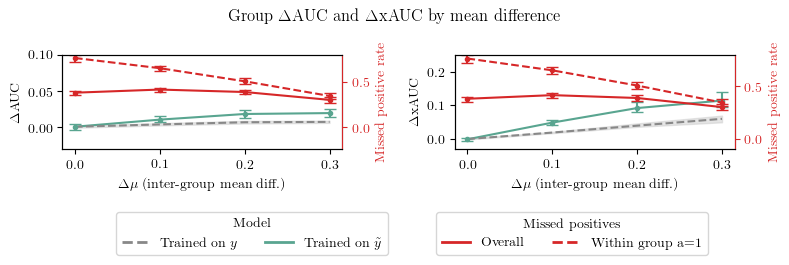

In [14]:
df_list = [
    pd.read_csv(f"results/SETTING2_5_6.6_md{i}/full.csv", index_col=0, quotechar="|") for i in [0, 0.1, 0.2, 0.3]
]
covariate_shift_boxplot(
    df_list, "figures/setting2_md.pdf",[0, 0.1, 0.2, 0.3],
    'Pr[T=1|A=1]_train',
    "Test rate (group 1)",
    title_suffix=" by mean difference",
    legend_title="Model",
    xlabel="$\Delta\mu$ (inter-group mean diff.)",
    title_mapping={"$\Delta\mu$": [0, 0.1, 0.2, 0.3]},
    lim=[(-0.03, 0.1), (-0.03, 0.25)],

)

# Setting 3: Plots

In [18]:
from scipy.interpolate import griddata

def degree_conditional_shift_plot(
    all_data,
    fname,
    metrics=["AUC", "xAUC"],
    ticklabels=range(0, 210, 30),
    title_suffix=", undertested high-risk group",
    experiment_name="SVMExperiment",
    experiment_xgap=0.5,
    group_xgap=0.1,
    start=0.5,
    padding=0.2,
    ci=95.,
    y_cmap="crest",
    y_obs_cmap="crest",
    lim=[(-0.05, 0.7), (-0.05, 0.4)],
    figsize=(3., 3.),
    title_mapping=None,
    legend_title=None,
):
    final_figsize = (figsize[0] * len(metrics), figsize[1])
    fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize=final_figsize)

    y_obs_colors = np.array(sns.color_palette(y_obs_cmap))

    lq, uq = (100 - ci) / 200, 1 - (100 - ci) / 200

    title = fig.suptitle(f"Group $\Delta$AUC, $\Delta$xAUC" + title_suffix)
    xmin = start 
    xmax = start + (len(all_data[0]) - 1) * experiment_xgap
    for r, metric in enumerate(metrics):
        metric_shortname = metric.split()[0].lower()
        axs[r].set_title(f"$\Delta${metric}")
        axs[r].set_ylabel("$P_1(t=0)$ (censorship rate, a=1)")
        axs[r].set_xlabel("Degrees (cond. shift)")
        axs[r].set_xlim(xmin, xmax)

        axs[r].set_xticks(np.arange(start, start + experiment_xgap * len(all_data[0]), experiment_xgap))
        axs[r].set_xticklabels(ticklabels)
        
        xs = [start + c * experiment_xgap for c in range(len(all_data[0]))]
        x = []
        y = []
        z = []
        for c, df_list in enumerate(all_data):
            # for each list of experiments for a given threshold, collate (degree, noise rate) pairs
            for j, df in enumerate(df_list):
                oracle_diff = np.abs(df[f"{metric_shortname}_oracle_A1"] - df[f"{metric_shortname}_oracle_A0"])
                if c == 0:
                    x.append(xs[j])
                    y.append(0) # interpolation -- boundary condition
                    z.append(oracle_diff.median())
                diff = np.abs(df[f"{metric_shortname}_{experiment_name}_A1"] - df[f"{metric_shortname}_{experiment_name}_A0"])
                x.append(xs[j])
                y.append(df['Pr[Y_obs!=Y|A=1]_train'].mean().item()) # mean noise rate
                z.append(diff.median())
    
        xx = np.linspace(start, start + experiment_xgap * len(df_list[0]), 100)
        yy = np.linspace(0, max(y), 100)
        grid_x, grid_y = np.meshgrid(xx, yy)
        zz = griddata((x, y), z, (grid_x, grid_y), method='cubic', rescale=True, fill_value=np.nan)
        res = axs[r].pcolormesh(xx, yy, zz, vmin=0, vmax=min(1, max(z)), cmap='jet', shading='nearest')
        fig.colorbar(res, ax=axs[r], orientation='vertical')

    fig.tight_layout()
    plt.savefig(fname, bbox_extra_artists=(title,), bbox_inches='tight')
    plt.show()
    return x, y, z, xx, yy    

## Setting 3, performance gaps under 2, 4, 6, 8, 10 rotated dimensions

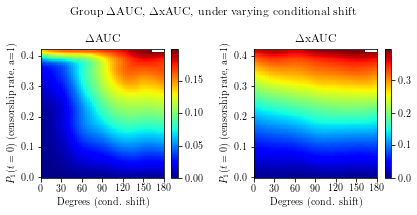

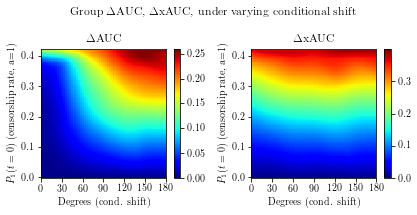

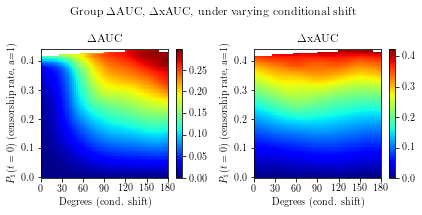

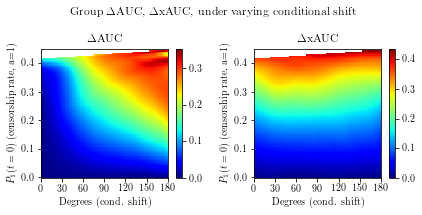

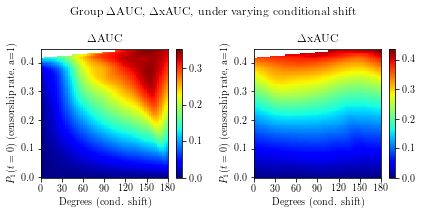

In [19]:
# Fig. 9 (conditional_shift_d4.pdf) + appendix figures for setting 3.
assert matplotlib.__version__ <= "3.4.3" # errors otherwise
for dimensions in [2, 4, 6, 8, 10]:
    df_list = [[
        pd.read_csv(f"results/SETTING3_5.0_{c}_deg{deg}_#rot{dimensions}/full.csv", 
                    index_col=0, 
                    quotechar="|") \
        for deg in range(0, 210, 30)
    ] for c in [5.0, 5.4, 5.8, 6.2, 6.6, 7.]]
    data = degree_conditional_shift_plot(
        df_list,
        f"figures/conditional_shift_d{dimensions}.pdf",
        title_suffix=", under varying conditional shift",
        experiment_name="RaceVaryingSVMExperiment",)